<img src="https://upload.wikimedia.org/wikipedia/fr/a/a4/Logo_dataiku.png" width=400>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Import data

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

%matplotlib inline

# Load Data with pandas, and add the first columns names (headers)
header_row=['age','class_of_worker','industry_code','occupation_code','education','wage_per_hour','enrolled_in_edu_inst_last_wk','marital_status','major_industry_code','major_occupation_code','race','hispanic_Origin','sex','member_of_a_labor_union','reason_for_unemployment','full_or_part_time_employment_stat','capital_gains','capital_losses','dividends_from_stocks','tax_filer_status','region_of_previous_residence','state_of_previous_residence','detailed_household_and_family_stat','detailed_household_summary_in_household','instance_weight','migration_code_change_in_msa','migration_code_change_in_reg','migration_code_move_within_reg','live_in_this_house_1_year_ago','migration_prev_res_in_sunbelt','num_persons_worked_for_employer','family_members_under_18','country_of_birth_father','country_of_birth_mother','country_of_birth_self','citizenship','own_business_or_self_employed','taxable_income_amount','veterans_benefits','weeks_worked_in_year','year','income']

train = pd.read_csv("us_census_full/census_income_learn.csv", names=header_row, encoding='utf-8', sep=",")
test = pd.read_csv("us_census_full/census_income_test.csv", names=header_row, encoding='utf-8', sep=",")

# Target is equal to 1 if income over 50 000
train['target'] = np.where(train['income']==' - 50000.',0,1)
test['target'] = np.where(test['income']==' - 50000.',0,1)

In [271]:
#Overview of the dataset
train.head()

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,taxable_income_amount,veterans_benefits,weeks_worked_in_year,year,income,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,0


# Feature exploration

## Use business rules

It's always interesting to study a well-known business rule.

__For example:__  
As a general rule, the FLSA (Fair Labor Standards Act) sets 14 years of age as the minimum age for employment.

In [3]:
train[(train.age<18) & (train.target == 1)]

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,taxable_income_amount,veterans_benefits,weeks_worked_in_year,year,income,target
20416,16,Private,32,18,10th grade,0,High school,Never married,Wholesale trade,Sales,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,50000+.,1
97025,17,Self-employed-incorporated,33,42,10th grade,0,High school,Never married,Retail trade,Handlers equip cleaners etc,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,24,95,50000+.,1


It represents 22% of the data set. Lets exclude them. Do not forget to predict them as false for test sample if we use the business rule.

In [4]:
print(100*len(train[(train.age<14)])/len(train))
#train = train[train.age>=14]

22.23001859434752


### Code to test efficiency of this rule

Let's test the business rule. 

**WARNING:** You have to execute "feature_engineering" block (see in "Feature Engineering" section)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

X_train = feature_engineering(train)

X_train_rest = X_train[X_train.age<14]
X_train = X_train[X_train.age>=14]

# Target : target
y_train = X_train.pop('target')
y_train_rest = X_train_rest.pop('target')


###############################

features_taken = ['age','wage_per_hour','weeks_worked_in_year','dividends_from_stocks','capital_gains','num_persons_worked_for_employer','capital_losses']

# Function that search and add in an array all split features thanks to their name (ex: 'industry_code' => 'split_industry_code_0', 'split_industry_code_1' ...)
# Input : 
#    features_array : array of features
#    array : array in which split features are added
def add_split_variables_to_array(features_array, array):
    for feature_name in features_array:
        feature_name = 'split_' + feature_name
        columns = [col for col in X_train.columns if feature_name in col]
        array = array + columns
    return array

split_features_to_be_added =['occupation_code','education','industry_code','major_industry_code','sex','major_occupation_code','class_of_worker','tax_filer_status','marital_status','own_business_or_self_employed','detailed_household_and_family_stat','member_of_a_labor_union','country_of_birth_father','country_of_birth_mother','detailed_household_summary_in_household','full_or_part_time_employment_stat','race']
#split_features_to_be_added = ['occupation_code','education','industry_code','major_industry_code','sex','major_occupation_code']
features_taken = add_split_variables_to_array(split_features_to_be_added, features_taken)

X_train_temp = X_train[features_taken]
X_train = X_train_temp

###############################

start_time = time.time()
lr = LogisticRegression()
lr.fit(X_train,y_train)
predicted = lr.predict_proba(X_train)

array_temp = [[0,1]]*len(X_train_rest)
predicted = np.concatenate((predicted,array_temp), axis=0)

y_train = np.concatenate((y_train,y_train_rest), axis=0)

error = log_loss(y_train,predicted)

print("log loss:" % error)
print("--- seconds %s ---" % (time.time() - start_time))

Error with the business rule : 0.1228  
Error without the business rule : 0.1229

The business rule is not efficient. Hopefully, even a simple model can catch this fact. But this rule can be very usefull in order to reduce by 22% the dataset if you want to perform powerfull but time consuming algorithms.

This is just a simple example to show that business rules have to be considered to interpret / to deal with data.

## Sparsing test

Let's see if the dataset is sparse are not.

We use missingno package to see very quicky if it's the case are not.

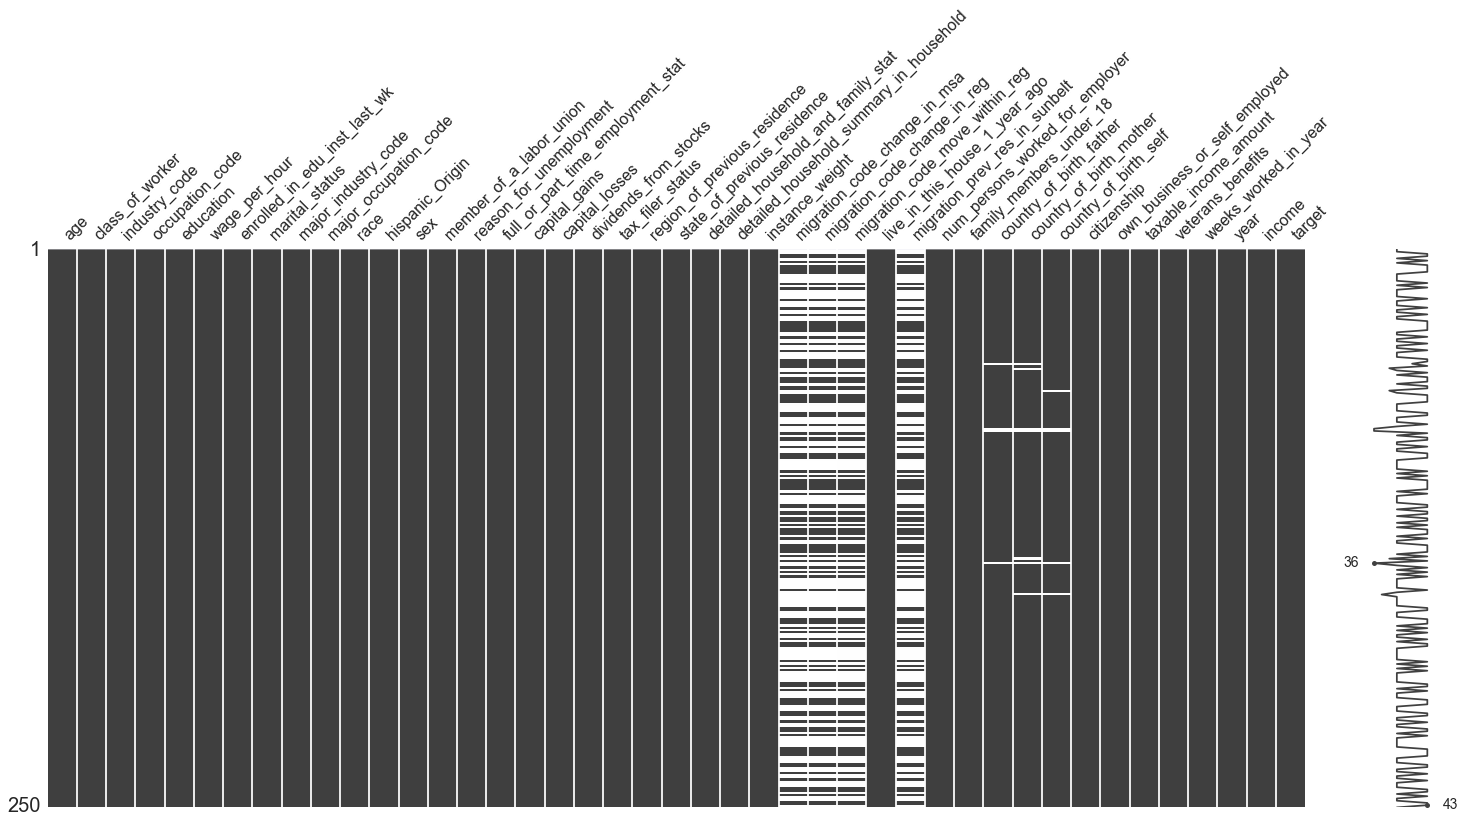

In [5]:
import missingno as msno
%matplotlib inline
msno.matrix(train.sample(250))

We can see that missing values are informations about migration informations.

There is not much informations missing because informations comes from US Census.

I don't think there is so much possibilities to use imputation technics.

## Basic statistics

### Summary statistics

In [167]:
summary = train.describe()
summary = summary.transpose()
summary.head()

,count,mean,std,min,25%,50%,75%,max
age,199523.0,34.494199,22.310895,0.0,15.0,33.0,50.0,90.0
industry_code,199523.0,15.352320,18.067129,0.0,0.0,0.0,33.0,51.0
occupation_code,199523.0,11.306556,14.454204,0.0,0.0,0.0,26.0,46.0
wage_per_hour,199523.0,55.426908,274.896454,0.0,0.0,0.0,0.0,9999.0
capital_gains,199523.0,434.718990,4697.531280,0.0,0.0,0.0,0.0,99999.0


### Corelation plot

Computing correlation


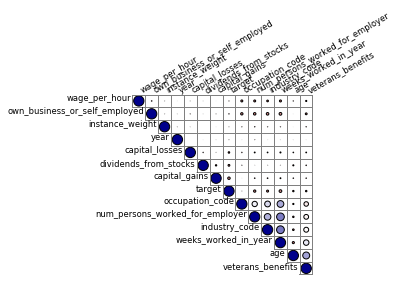

In [157]:
from biokit.viz import corrplot
c = corrplot.Corrplot(train.select_dtypes(include=['float64','int64']))
c.plot(colorbar=False, shrink=.8, upper='circle')

### Some descriptive plots

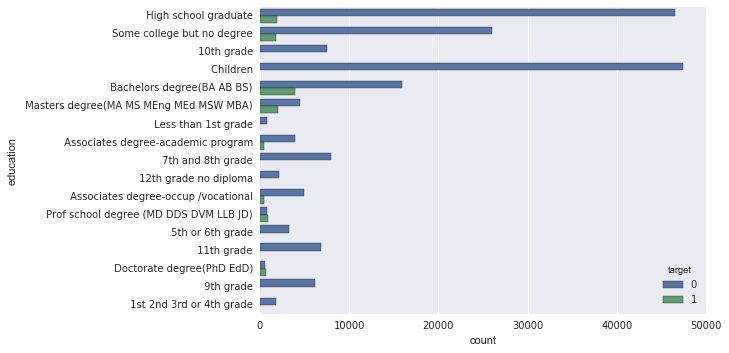

In [180]:
sns.countplot(y="education", hue="target", data=train, orient="h");

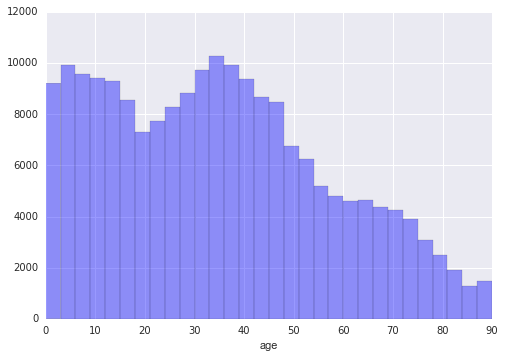

In [214]:
sns.distplot(train.age, kde=False, color="b", bins=30)

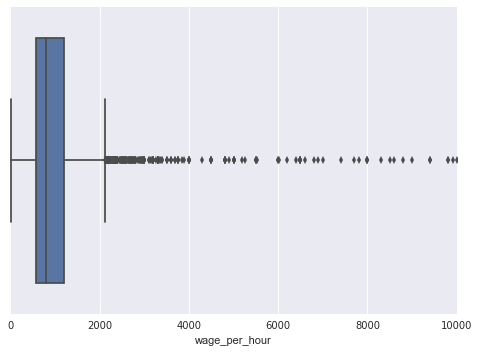

In [201]:
sns.boxplot(x=train.wage_per_hour[train.wage_per_hour!=0])

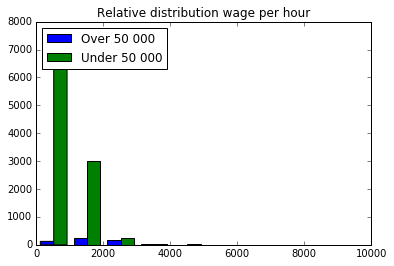

In [170]:
x1 = train.wage_per_hour[(train.wage_per_hour!=0) & (train.target==1)]
x2 = train.wage_per_hour[(train.wage_per_hour!=0) & (train.target==0)]
plt.hist([x1, x2], label=['Over 50 000', 'Under 50 000'])#,color = ['', 'b'])
plt.legend(loc = 'upper left')
plt.title('Relative distribution wage per hour')
plt.show()

# Feature Engineering

We dummies categorical variable and delete income variable (replaced by target variable).

In [272]:
def feature_engineering(X):
    
    # Convert ? by default python NaN
    X = X.replace(' ?', np.NaN)
    
    #Imputation
    
    #Working with education feature
    def group_education(value):
        if value in [' Some college but no degree','10th grade',' Children',' Less than 1st grade',' 7th and 8th grade',
        ' 12th grade no diploma',' 5th or 6th grade',' 11th grade',' 9th grade',' 1st 2nd 3rd or 4th grade']:
            value = 'Undergrade'
        elif value in  ['High school graduate', ' Some college but no degree']:
            value = "Grad but not Bachelor or Master"
        elif value in  [' Masters degree(MA MS MEng MEd MSW MBA)',' Prof school degree (MD DDS DVM LLB JD)']:
            value = "Master"
        elif value in [' Associates degree-academic program', 'Associates degree-occup /vocational']:
            value = "Other"
        else:
            value = value
        return value
    #X['education'] = X['education'].apply(group_education)

    # Features to dummy
    #to_dummy = []
    to_dummy = ['occupation_code','education','industry_code','major_industry_code','sex','major_occupation_code','class_of_worker','tax_filer_status','marital_status','own_business_or_self_employed','detailed_household_and_family_stat','member_of_a_labor_union','country_of_birth_father','country_of_birth_mother','detailed_household_summary_in_household','full_or_part_time_employment_stat','race']
    for dum in to_dummy :
        dum_temp = dum.replace(" ", "_")
        split_temp = pd.get_dummies(X[dum], prefix='split_'+dum_temp)
        for col in split_temp :
            col_temp = col.replace(" ", "_")
            col_temp = col_temp.replace("<","under_")
            X[col_temp] = split_temp[col]
        del X[dum]
    
    # Features to delete
    to_del = ['income','instance_weight']
    for col in to_del : del X[col]
    
    return X

# Feature selection

## Random Forest

We do a random forest to do feature selection.

In [ ]:
X_train = train

# Target : target
y_train = X_train.pop('target')

In [21]:
from sklearn import preprocessing

def convert(data, categorical_data):
    number = preprocessing.LabelEncoder()
    for cat in categorical_data:
        data[cat] = number.fit_transform(data[cat])
    data=data.fillna(-999)
    return data

X_train = X_train.drop('income', 1)
X_train = X_train.drop('instance_weight', 1)

categorical_data = ['class_of_worker','industry_code','occupation_code','education','enrolled_in_edu_inst_last_wk','marital_status','major_industry_code','major_occupation_code','race','hispanic_Origin','sex','member_of_a_labor_union','reason_for_unemployment','full_or_part_time_employment_stat','tax_filer_status','region_of_previous_residence','state_of_previous_residence','detailed_household_and_family_stat','detailed_household_summary_in_household','migration_code_change_in_msa','migration_code_change_in_reg','migration_code_move_within_reg','live_in_this_house_1_year_ago','migration_prev_res_in_sunbelt','family_members_under_18','country_of_birth_father','country_of_birth_mother','country_of_birth_self','citizenship','own_business_or_self_employed','taxable_income_amount','veterans_benefits']
X_train = convert(X_train, categorical_data)

We have to convert categorical features to integer to run the random forest

In [22]:
X_train.head()

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,taxable_income_amount,veterans_benefits,weeks_worked_in_year,year
0,73,3,0,0,12,0,2,6,14,6,...,4,40,40,40,4,0,1,2,0,95
1,58,6,4,34,16,0,2,0,4,8,...,4,40,40,40,4,0,1,2,52,94
2,18,3,0,0,0,0,1,4,14,6,...,4,41,41,41,0,0,1,2,0,95
3,9,3,0,0,10,0,2,4,14,6,...,0,40,40,40,4,0,1,0,0,94
4,10,3,0,0,10,0,2,4,14,6,...,0,40,40,40,4,0,1,0,0,94


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(train.shape[1]):
    print ("%d. feature : %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

1. feature : age (0.117727)
2. feature : occupation_code (0.097561)
3. feature : dividends_from_stocks (0.095593)
4. feature : capital_gains (0.079395)
5. feature : industry_code (0.069285)
6. feature : education (0.059737)
7. feature : num_persons_worked_for_employer (0.048052)
8. feature : weeks_worked_in_year (0.040385)
9. feature : major_industry_code (0.037779)
10. feature : sex (0.035195)
11. feature : class_of_worker (0.029439)
12. feature : capital_losses (0.029362)
13. feature : major_occupation_code (0.026440)
14. feature : detailed_household_and_family_stat (0.018124)
15. feature : tax_filer_status (0.016936)
16. feature : marital_status (0.015990)
17. feature : own_business_or_self_employed (0.015908)
18. feature : country_of_birth_father (0.015197)
19. feature : country_of_birth_mother (0.014619)
20. feature : member_of_a_labor_union (0.014440)
21. feature : wage_per_hour (0.012623)
22. feature : full_or_part_time_employment_stat (0.011872)
23. feature : detailed_household_summary_in_household (0.011467)
24. feature : race (0.010820)
25. feature : country_of_birth_self (0.008389)
26. feature : hispanic_Origin (0.007774)
27. feature : citizenship (0.006603)
28. feature : migration_code_move_within_reg (0.006537)
29. feature : migration_prev_res_in_sunbelt (0.006479)
30. feature : migration_code_change_in_reg (0.006205)
31. feature : migration_code_change_in_msa (0.006043)
32. feature : live_in_this_house_1_year_ago (0.005669)
33. feature : state_of_previous_residence (0.005074)
34. feature : year (0.004125)
35. feature : region_of_previous_residence (0.003510)
36. feature : family_members_under_18 (0.002610)
37. feature : reason_for_unemployment (0.002590)
38. feature : taxable_income_amount (0.001992)
39. feature : veterans_benefits (0.001871)
40. feature : enrolled_in_edu_inst_last_wk (0.000581)

Now, the random forest has given the list of the most important features to predict the target.

In order to reduce more the number of variable we can do our variable selection after the dummification.

In [45]:
X_train = feature_engineering(train)
#X_train = train

# Target : target
y_train = X_train.pop('target')

Warning: Have to run feature_engineering function and the final feature selection before

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(train.shape[1]):
    print ("%d. feature : %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

1. feature : age (0.101595)
2. feature : dividends_from_stocks (0.082604)
3. feature : capital_gains (0.071861)
4. feature : num_persons_worked_for_employer (0.045616)
5. feature : weeks_worked_in_year (0.028694)
6. feature : capital_losses (0.022910)
7. feature : split_major_occupation_code__Executive_admin_and_managerial (0.022633)
8. feature : split_sex__Female (0.015609)
9. feature : split_occupation_code_2 (0.015127)
10. feature : split_education__Masters_degree(MA_MS_MEng_MEd_MSW_MBA) (0.014904)
11. feature : split_sex__Male (0.014442)
12. feature : split_class_of_worker__Not_in_universe (0.014424)
13. feature : split_education__Bachelors_degree(BA_AB_BS) (0.014053)
14. feature : split_full_or_part_time_employment_stat__Children_or_Armed_Forces (0.014014)
15. feature : split_full_or_part_time_employment_stat__Full-time_schedules (0.013382)
16. feature : split_major_occupation_code__Professional_specialty (0.013004)
17. feature : split_education__High_school_graduate (0.012297)
18. feature : split_marital_status__Married-civilian_spouse_present (0.012026)
19. feature : split_education__Prof_school_degree_(MD_DDS_DVM_LLB_JD) (0.011049)
20. feature : split_education__Some_college_but_no_degree (0.010357)
21. feature : wage_per_hour (0.009890)
22. feature : split_detailed_household_and_family_stat__Householder (0.009679)
23. feature : split_own_business_or_self_employed_0 (0.009413)
24. feature : split_class_of_worker__Private (0.008747)
25. feature : split_member_of_a_labor_union__Not_in_universe (0.008741)
26. feature : split_class_of_worker__Self-employed-incorporated (0.008103)
27. feature : split_own_business_or_self_employed_2 (0.007892)
28. feature : split_member_of_a_labor_union__No (0.007820)
29. feature : split_country_of_birth_father__United-States (0.007631)
30. feature : split_country_of_birth_mother__United-States (0.007344)
31. feature : split_education__Doctorate_degree(PhD_EdD) (0.006748)
32. feature : split_race__White (0.006296)
33. feature : split_tax_filer_status__Joint_both_under_65 (0.006287)
34. feature : split_occupation_code_11 (0.005682)
35. feature : split_occupation_code_7 (0.005584)
36. feature : split_own_business_or_self_employed_1 (0.005394)
37. feature : split_class_of_worker__Self-employed-not_incorporated (0.005388)
38. feature : split_major_industry_code__Manufacturing-durable_goods (0.005318)
39. feature : split_detailed_household_and_family_stat__Spouse_of_householder (0.005142)
40. feature : split_occupation_code_4 (0.005045)
41. feature : split_race__Black (0.004572)
42. feature : split_detailed_household_summary_in_household__Householder (0.004521)
43. feature : split_industry_code_45 (0.004512)

## Final features selection

### All the 20 best features before dummy

We take the best 20 features from the random forest before spliting categorical features.

In [273]:
X_train = feature_engineering(train)
#X_train = train

# Target : target
y_train = X_train.pop('target')

Thanks to the random forest we can select the most important features.

In [274]:
# Function that search and add in an array all split features thanks to their name (ex: 'industry_code' => 'split_industry_code_0', 'split_industry_code_1' ...)
# Input : 
#    features_array : array of features
#    array : array in which split features are added
def add_split_variables_to_array(features_array, array,X):
    for feature_name in features_array:
        feature_name = 'split_' + feature_name
        columns = [col for col in X.columns if feature_name in col]
        array = array + columns
    return array

In [275]:
features_taken = ['age','wage_per_hour','weeks_worked_in_year','dividends_from_stocks','capital_gains','num_persons_worked_for_employer','capital_losses']
split_features_to_be_added =['occupation_code','education','industry_code','major_industry_code','sex','major_occupation_code','class_of_worker','tax_filer_status','marital_status','own_business_or_self_employed','detailed_household_and_family_stat','member_of_a_labor_union','country_of_birth_father','country_of_birth_mother','detailed_household_summary_in_household','full_or_part_time_employment_stat','race']

features_taken = add_split_variables_to_array(split_features_to_be_added, features_taken, X_train)

In [276]:
X_train_temp = X_train[features_taken]
X_train = X_train_temp

In [277]:
X_train.head()

,age,wage_per_hour,weeks_worked_in_year,dividends_from_stocks,capital_gains,num_persons_worked_for_employer,capital_losses,split_occupation_code_0,split_occupation_code_1,split_occupation_code_2,...,split_full_or_part_time_employment_stat__PT_for_econ_reasons_usually_FT,split_full_or_part_time_employment_stat__PT_for_econ_reasons_usually_PT,split_full_or_part_time_employment_stat__PT_for_non-econ_reasons_usually_FT,split_full_or_part_time_employment_stat__Unemployed_full-time,split_full_or_part_time_employment_stat__Unemployed_part-_time,split_race__Amer_Indian_Aleut_or_Eskimo,split_race__Asian_or_Pacific_Islander,split_race__Black,split_race__Other,split_race__White
0,73,0,0,0,0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,58,0,52,0,0,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,18,0,0,0,0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,9,0,0,0,0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,10,0,0,0,0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### All the 20 best features after spliting categorical features

In [228]:
X_train = feature_engineering(train)
#X_train = train

# Target : target
y_train = X_train.pop('target')

In [231]:
features_taken = ['age','dividends_from_stocks','capital_gains','num_persons_worked_for_employer','weeks_worked_in_year','capital_losses','split_major_occupation_code__Executive_admin_and_managerial','split_sex__Female','split_occupation_code_2','split_education__Masters_degree(MA_MS_MEng_MEd_MSW_MBA)','split_sex__Male','split_class_of_worker__Not_in_universe','split_education__Bachelors_degree(BA_AB_BS)','split_full_or_part_time_employment_stat__Children_or_Armed_Forces','split_full_or_part_time_employment_stat__Full-time_schedules','split_major_occupation_code__Professional_specialty','split_education__High_school_graduate','split_marital_status__Married-civilian_spouse_present','split_education__Prof_school_degree_(MD_DDS_DVM_LLB_JD)','split_education__Some_college_but_no_degree']

X_train_temp = X_train[features_taken]
X_train = X_train_temp

In [232]:
X_train.head()

,age,dividends_from_stocks,capital_gains,num_persons_worked_for_employer,weeks_worked_in_year,capital_losses,split_major_occupation_code__Executive_admin_and_managerial,split_sex__Female,split_occupation_code_2,split_education__Masters_degree(MA_MS_MEng_MEd_MSW_MBA),split_sex__Male,split_class_of_worker__Not_in_universe,split_education__Bachelors_degree(BA_AB_BS),split_full_or_part_time_employment_stat__Children_or_Armed_Forces,split_full_or_part_time_employment_stat__Full-time_schedules,split_major_occupation_code__Professional_specialty,split_education__High_school_graduate,split_marital_status__Married-civilian_spouse_present,split_education__Prof_school_degree_(MD_DDS_DVM_LLB_JD),split_education__Some_college_but_no_degree
0,73,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,58,0,0,1,52,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,18,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Models

## Logistic regression

In [279]:
from sklearn.cross_validation import cross_val_score
def compute_score(clf, X, y):
    xval = cross_val_score(clf, X, y, cv = 5, scoring = "log_loss")
    return np.mean(xval)

from sklearn.linear_model import LogisticRegression

start_time = time.time()
lr = LogisticRegression()
mean = compute_score(lr, X_train, y_train)
print(mean)
print("--- seconds %s ---" % (time.time() - start_time))

-0.124636616016
--- seconds 48.10120391845703 ---


Score for base model : 0.1842 (3.04 secondes)

Model :
- LogisticRegression   
- Scoring : Log_loss   
- Features : ['age','wage_per_hour','weeks_worked_in_year']
- No modification on the dataset

**Add dummy variable occupation_code**  
Score: 0.1553 (6.67 s)

**Add continuous variable dividends_from_stocks**  
Score: 0.1494 (7.79 s)

**Add continuous variable capital_gains**  
Score: 0.1442 (9.17 s)

**Add dummy variable education**  
Score: 0.1360 (10.74 s)

**Add dummy variable industry_code**  
Score: 0.1330 (13.49 s)

**Add continuous num_persons_worked_for_employer**  
Score: 0.1321 (14.24 s)

**Add dummy variable major_industry_code**  
Score: 0.1321 (17.54 s)

**Add dummy variable sex**  
Score: 0.1282 (16.80 s)

**Add dummy variable major_occupation_code**  
Score: 0.1281 (25.94 s)



**Add dummy variables :** 
- class_of_worker
- tax_filer_status
- marital_status
- own_business_or_self_employed
- detailed_household_and_family_stat
- member_of_a_labor_union
- country_of_birth_father
- member_of_a_labor_union
- country_of_birth_mother
- detailed_household_summary_in_household
- full_or_part_time_employment_stat
- race

**and continuous variable:**  
- capital_losses

Score: 0.1243 (40.50 s)



**Add default NaN variable**
Score: 0.1241 (44.70 s)


If we take the **20 best features after spliting categorical features**, we have :  
Score: 0.1364 (11.28 s)

We improve the performance and without loosing so much in scoring.  
That can be easily understand because we have selected splited features thanks to a random forest, which selected the most important features.

## Logistic Regression with regularization

In [ ]:
from sklearn.cross_validation import cross_val_score
def compute_score(clf, X, y):
    xval = cross_val_score(clf, X, y, cv = 5, scoring = "log_loss")
    return np.mean(xval)

from sklearn.linear_model import SGDClassifier

start_time = time.time()
lr = SGDClassifier(loss='log', n_iter=1000, alpha=1, penalty="l2")
mean = compute_score(lr, X_train, y_train)
print(mean)
print("--- seconds %s ---" % (time.time() - start_time))

## Xgboost

We will take the example of Xgboost to show how to find the best hyperparameters.

### Gridsearch for Xgboost: Learning Rate

In [ ]:
from sklearn.cross_validation import cross_val_score

import xgboost as xgb

from sklearn.grid_search import GridSearchCV
from xgboost.sklearn import XGBClassifier

start_time = time.time()
model = XGBClassifier(n_estimators=400, max_depth=3, objective="binary:logistic")
parameters = {'learning_rate':[0.05,0.07,0.1,0.15,0.2,0.25]}

clf = GridSearchCV(model, parameters, cv = 5, scoring = "log_loss",n_jobs=-1, verbose=10)
clf.fit(X_train, y_train)

print(clf.grid_scores_)

print("--- seconds %s ---" % (time.time() - start_time))

**Results:**


| Learning Rate|Score log loss| 
| - | -: |
| 0.05 |0.11677|
| 0.07 |0.11531|
| 0.1  |0.11403| 
|0.15|0.11252|
|0.2|0.11166|
|0.25|0.11129|


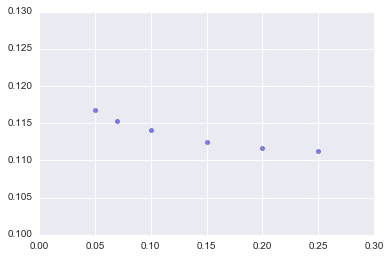

In [13]:
import numpy as np
import matplotlib.pyplot as plt


x = [0.05,0.07,0.1,0.15,0.2,0.25]
y = [0.11677,0.11531,0.11403,0.11252,0.11166,0.11129]

plt.scatter(x, y, alpha=0.5)
plt.show()

### Gridsearch for Xgboost: Number of estimators

In [ ]:
from sklearn.cross_validation import cross_val_score

import xgboost as xgb

from sklearn.grid_search import GridSearchCV
from xgboost.sklearn import XGBClassifier

start_time = time.time()
model = XGBClassifier(max_depth=3, objective="binary:logistic")
parameters = {'n_estimators':[100,300,600,900,1200,1500]}

clf = GridSearchCV(model, parameters, cv = 5, scoring = "log_loss",n_jobs=-1, verbose=10)
clf.fit(X_train, y_train)

print(clf.grid_scores_)

print("--- seconds %s ---" % (time.time() - start_time))

**Results:**


| Nummber of estimators|Score log loss| 
| - | -: |
| 100 |0.12138|
| 300 |0.11498|
| 600  |0.11252| 
|900|0.11134|
|1200|0.11071|
|1500|0.11034|


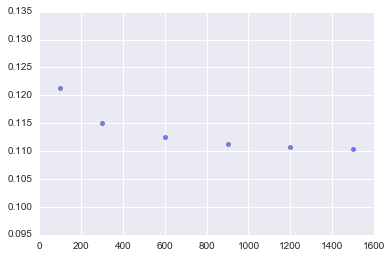

In [14]:
import numpy as np
import matplotlib.pyplot as plt


x = [100,300,600,900,1200,1500]
y = [0.12138,0.11498,0.11252,0.11134,0.11071,0.11034]

plt.scatter(x, y, alpha=0.5)
plt.show()

### Gridsearch for Xgboost: Max depth

In [ ]:
from sklearn.cross_validation import cross_val_score

import xgboost as xgb

from sklearn.grid_search import GridSearchCV
from xgboost.sklearn import XGBClassifier

start_time = time.time()
model = XGBClassifier(n_estimators=400, objective="binary:logistic")
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9]}

clf = GridSearchCV(model, parameters, cv = 5, scoring = "log_loss",n_jobs=-1, verbose=10)
clf.fit(X_train, y_train)

print(clf.grid_scores_)

print("--- seconds %s ---" % (time.time() - start_time))

**Results:**


| Number of estimators|Score log loss| 
| - | -: |
|1|0.12244|
|2|0.11659|
|3|0.11403| 
|4|0.11219|
|5|0.11115|
|6|0.11080|
|7|0.11086|
|8|0.11132|
|9|0.11185|

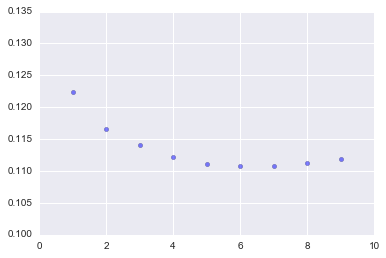

In [15]:
import numpy as np
import matplotlib.pyplot as plt


x = [1,2,3,4,5,6,7,8,9]
y = [0.12244,0.11659,0.11403,0.11219,0.11115,0.11080,0.11086,0.11132,0.11185]

plt.scatter(x, y, alpha=0.5)
plt.show()

### Xgboost execution and evaluation

In [ ]:
from sklearn.cross_validation import cross_val_score
from xgboost.sklearn import XGBClassifier

def compute_score(clf, X, y):
    xval = cross_val_score(clf, X, y, cv = 5, scoring = "log_loss")
    return np.mean(xval)

start_time = time.time()
model_xgboost = XGBClassifier(max_depth=7 ,n_estimators=1200,learning_rate=0.20 , objective="binary:logistic")
mean = compute_score(model_xgboost, X_train, y_train)
print(mean)
print("--- seconds %s ---" % (time.time() - start_time))

**Log loss:** 0.1222

# Comparison between logistic regression and xgboost

## ROC curve

Area under the ROC curve for regression : 0.945592
Area under the ROC curve for xgboost : 0.993707


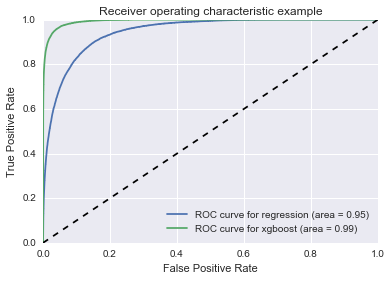

In [18]:
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

lr = LogisticRegression()
lr.fit(X_train,y_train)
proba_regression = lr.predict_proba(X_train)

# proba_regression est une matrice de deux colonnes avec la probabilités d'appartenance à chaque classe
fpr_reg, tpr_reg, thresholds_reg = roc_curve(y_train, proba_regression[:, 1])
roc_auc_reg = auc(fpr_reg, tpr_reg)

model_xgboost = XGBClassifier(max_depth=7 ,n_estimators=1200,learning_rate=0.20 , objective="binary:logistic")
model_xgboost.fit(X_train,y_train)
proba_xgboost = model_xgboost.predict_proba(X_train)

# proba_xgboost est une matrice de deux colonnes avec la probabilités d'appartenance à chaque classe
fpr_xgboost, tpr_xgboost, thresholds_reg = roc_curve(y_train, proba_xgboost[:, 1])
roc_auc_xgboost = auc(fpr_xgboost, tpr_xgboost)

print ("Area under the ROC curve for regression : %f" % roc_auc_reg)
print ("Area under the ROC curve for xgboost : %f" % roc_auc_xgboost)

plt.plot(fpr_reg, tpr_reg, label='ROC curve for regression (area = %0.2f)' % roc_auc_reg)
plt.plot(fpr_xgboost, tpr_xgboost, label='ROC curve for xgboost (area = %0.2f)' % roc_auc_xgboost)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

# Submition

Don't forget to run feature_engineering function and add_split_variables_to_array custom function

In [122]:
X_train = feature_engineering(train)
y_train = X_train.pop('target')

X_test = feature_engineering(test)
y_test = X_test.pop('target')

In [124]:
features_taken = ['age','wage_per_hour','weeks_worked_in_year','dividends_from_stocks','capital_gains','num_persons_worked_for_employer','capital_losses']
split_features_to_be_added =['occupation_code','education','industry_code','major_industry_code','sex','major_occupation_code','class_of_worker','tax_filer_status','marital_status','own_business_or_self_employed','detailed_household_and_family_stat','member_of_a_labor_union','country_of_birth_father','country_of_birth_mother','detailed_household_summary_in_household','full_or_part_time_employment_stat','race']

features_taken_temp = add_split_variables_to_array(split_features_to_be_added, features_taken, X_train)
X_train_temp = X_train[features_taken_temp]
X_train = X_train_temp

features_taken_temp = add_split_variables_to_array(split_features_to_be_added, features_taken, X_test)
X_test_temp = X_test[features_taken_temp]
X_test = X_test_temp

We use our best model:

In [ ]:
from xgboost.sklearn import XGBClassifier

start_time = time.time()
model = XGBClassifier(max_depth=7 ,n_estimators=1200,learning_rate=0.20 , objective="binary:logistic")
clf = model.fit(X_train, y_train)

X_test['split_detailed_household_and_family_stat__Grandchild_under_18_ever_marr_not_in_subfamily']=0
X_test = X_test[list(X_train.columns.values)]

predicted = model.predict_proba(X_test)

In [152]:
from sklearn.metrics import log_loss
error = log_loss(y_test, predicted)
print('Log loss: ')
print(error)

Log loss: 
0.114678940938


**Log loss:**
0.1147

# Conclusion

We have seen 3 differents algorithms :

- 1 - A radom forest for the features selection
- 2 - A regularised (l2) logistic regression as a base algorithm to help the feature engineering
- 3 - Xgboost to show how to fix hyperparmeters

We have compared the prediction of each method and test if we have done a great work by evaluating the test dataset.

I choose *log loss* to evaluate the efficiency of prediction because we can **evaluate how sure the algorithm is** thanks to the probabilities of each class and **not only if the algorithm as right or wrong** for each line.





<center>**Made by Olivier NGUYEN QUOC**  
Msc in Business Analytics and Data Sciences  
Graduated from Centrale Nantes</center>